Now we want to obtain a very good intuitive understanding about the activations of a neural net during training, and especially their gradients -- how they behave and what they look like.

This is going to be very important to understand the history of the development of various architectures. We will see that while recurrent neural networks are universal approximators and can in principle "implement all the algorithms", they are not easy to optimize using the first-order gradient-based techniques we usually use. The key to understanding why they aren't easily optimizable is to understand activations and gradients during training. We'll see how other variants since (vanilla) RNNs have tried to improve that.

In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import Tensor, Generator
import random

from karpathy_nn.makemore.data.load_data import load_names
from typing import Optional


In [36]:
random.seed(42)


In [37]:
words = load_names()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [38]:
len(words)


32033

In [39]:
# Build the vocabuilary of tokens and mappings to/from integers
characters = sorted(list(set("".join(words))))
string_to_integer = {string: integer + 1 for integer, string in enumerate(characters)}
string_to_integer["."] = 0
integer_to_string = {integer: string for string, integer in string_to_integer.items()}
num_tokens = len(integer_to_string)
print(integer_to_string)
print(num_tokens)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [40]:
def build_dataset(words: list[str], block_size: int = 3) -> tuple[Tensor, Tensor]:
    # Create the dataset
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for character in word + ".":
            idx = string_to_integer[character]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]  # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size = 3
Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)


In [41]:
# MLP revisited
dim_embedding = 10
dim_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)
W1 = torch.randn(dim_embedding * block_size, dim_hidden, generator=g)
b1 = torch.randn(dim_hidden, generator=g)
W2 = torch.randn(dim_hidden, num_tokens, generator=g) * 0.01
b2 = torch.zeros(num_tokens)

parameters = [C, W1, b1, W2, b2]
print(sum(parameter.nelement() for parameter in parameters))
for parameter in parameters:
    parameter.requires_grad = True


11897


In [42]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    embedding_cat = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    hidden_pre_activation = embedding_cat @ W1 + b1
    hidden_activation = torch.tanh(hidden_pre_activation)
    logits = hidden_activation @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    # if i % 50000 == 0:
    #     print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())  # Trends are easier to see, no huge changes


Without weight downscaling, at initialization we have a training loss of 27. This rapidly decreases. We can already tell that the initialization is messed up because this loss value is way too high. At initialization, we want to predict a uniform distribution over the upcoming character, because we have no reason to believe any character to be more likely than the others. We want
$$p(\text{next character} \mid X) = \frac{1}{27}.$$
The loss is the negative log-probability of the GT character:
$$\log p(\text{GT next character} \mid X) = \log 27 \approx 3.2958.$$
Thus, at initialization, the neural network creates distributions that are all messed up. Some characters are predicted more confidently than the others. The network is quite confidently wrong in many cases, resulting in a higher initial loss than for random guessing.

We want the logits to be roughly constant when the network is initialized, as that corresponds to a uniform distribution. We can just pick them to be all zeros. How can we achieve that? Because we want 0 logits, we don't want to add any bias, so we set ``b2`` to 0. We are multiplying ``hidden_activation`` by ``W2``, so if we want to achieve small logits, we can just make the ``W2`` values small. We can do this by e.g. scaling ``W2`` by 0.01.

Weights should always be small numbers instead of exact zeroes. This is because we need to break symmetry, and if the output probability distribution has entropy (but small entropy), we achieve exactly that.

When employing this new initialization scheme, we can see that the loss doesn't have this hockey stick appearance anymore. This is because with the incorrect initialization, in the very first steps, the optimization is just squashing down the logits. Only after that is it actually rearranging the logits. By initializing correctly, we take away this easy weight squashing part, so we can only obtain gains by actually training the neural net.

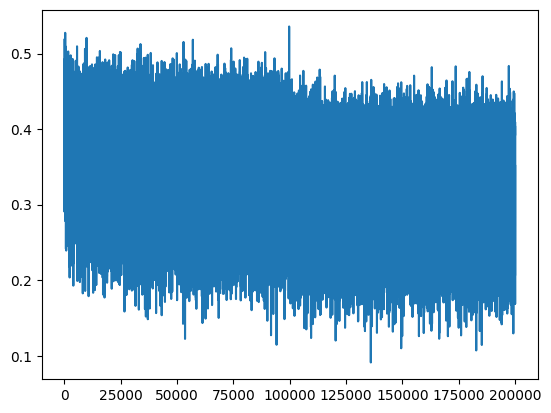

In [43]:
_ = plt.plot(lossi)


In [44]:
@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    embedding = C[x]  # (N, block_size, dim_embedding)
    embedding_cat = embedding.flatten(start_dim=1)  # (N, block_size * dim_embedding)
    hidden_activation = torch.tanh(embedding_cat @ W1 + b1)  # (N, dim_hidden)
    logits = hidden_activation @ W2 + b2  # (N, num_tokens)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")


train 2.0698375701904297
val 2.1326260566711426


If we compare the above results with the incorrectly initialized net, we can see that correct initialization actually leads to better results in the same number of steps. This is because we are spending more time actually optimizing the neural net, instead of just squashing down the weights.

In [45]:
# Sampe from the model
g = torch.Generator().manual_seed(3147483657)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        embedding = C[context]  # (block_size, dim_embedding)
        hidden_activation = torch.tanh(embedding.view(1, -1) @ W1 + b1)
        logits = hidden_activation @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # Sample from the distribution
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()

        # Shift the context window
        context = context[1:] + [idx]

        # If we sample the special "." token, break
        if idx == 0:
            break

        out.append(idx)
    print(
        "".join(integer_to_string[i] for i in out)
    )  # Decode and print the generated word


mio
arson
eli
zaidencelynn
gralya
anon
anashon
adah
jaxxpelseem
hed
mazel
breon
dan
avishaylyn
jamale
jayzonelle
delo
cacv
eyannin
ston


There are still some problems in our network, namely with the ``hidden_activation``.

In [46]:
# MLP revisited
dim_embedding = 10
dim_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)
W1 = torch.randn(dim_embedding * block_size, dim_hidden, generator=g)
b1 = torch.randn(dim_hidden, generator=g)
W2 = torch.randn(dim_hidden, num_tokens, generator=g) * 0.01
b2 = torch.zeros(num_tokens)  # Sometimes these are also just multiplied by 0.01
# Andrej finds that initializing non-zero biases can also help training sometimes

parameters = [C, W1, b1, W2, b2]
print(sum(parameter.nelement() for parameter in parameters))
for parameter in parameters:
    parameter.requires_grad = True


11897


In [47]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    embedding_cat = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    hidden_pre_activation = embedding_cat @ W1 + b1
    hidden_activation = torch.tanh(hidden_pre_activation)  # (32, dim_hidden)
    logits = hidden_activation @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    # if i % 50000 == 0:
    #     print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())  # Trends are easier to see, no huge changes

    break


In [48]:
hidden_activation


tensor([[-0.9809, -1.0000, -1.0000,  ..., -0.9859, -0.9999, -1.0000],
        [-0.9975,  0.9999, -0.5886,  ..., -0.9259, -0.9993,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        ...,
        [-1.0000,  0.8355, -1.0000,  ...,  0.9955, -1.0000, -0.8750],
        [-0.9793, -0.9999, -1.0000,  ...,  0.7836, -0.7058,  0.2913],
        [-0.6816, -1.0000, -1.0000,  ...,  1.0000, -0.6587, -0.9990]],
       grad_fn=<TanhBackward0>)

The problem is that many of the elements are already one or negative one. In regions close to plus or minus one, the gradient is almost 0, which prohibits learning.

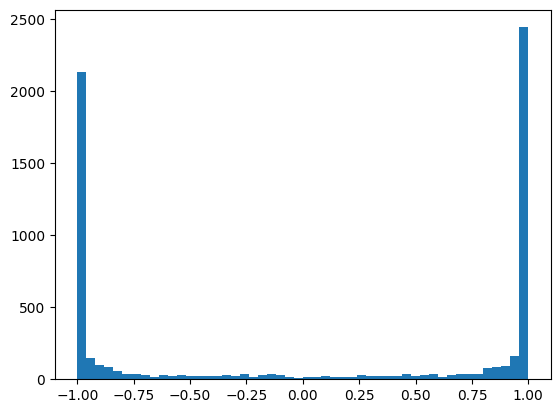

In [49]:
_ = plt.hist(hidden_activation.view(-1).detach().numpy(), bins=50)


Most entries take on value -1 or 1. The tanh is very active. We can look at the pre-activations that feed into the tanh to understand why this is the case:

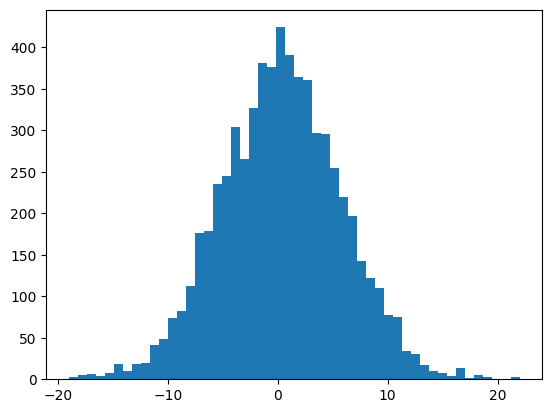

In [50]:
_ = plt.hist(hidden_pre_activation.view(-1).detach().numpy(), 50)


The distribution of pre-activations is very-very broad. Many entries take on values far away from 0. That's why the tanh is very active at most entries. This prohibits the network from learning, because
$$\text{tanh}'(x) = 1 - \text{tanh}^2(x).$$
If the input to tanh has large magnitude, $\text{tanh}(x)$ will be close to plus/minus one. Therefore, the gradient will be close to zero. If we perform backpropagation, this means that the incoming gradient gets zeroed out for the neuron in question. On the other hand, when the input to the tanh is 0, the gradient is one (maximal), so the incoming gradient will just pass through. How many times do we run into this problem?

tensor(0.6214)


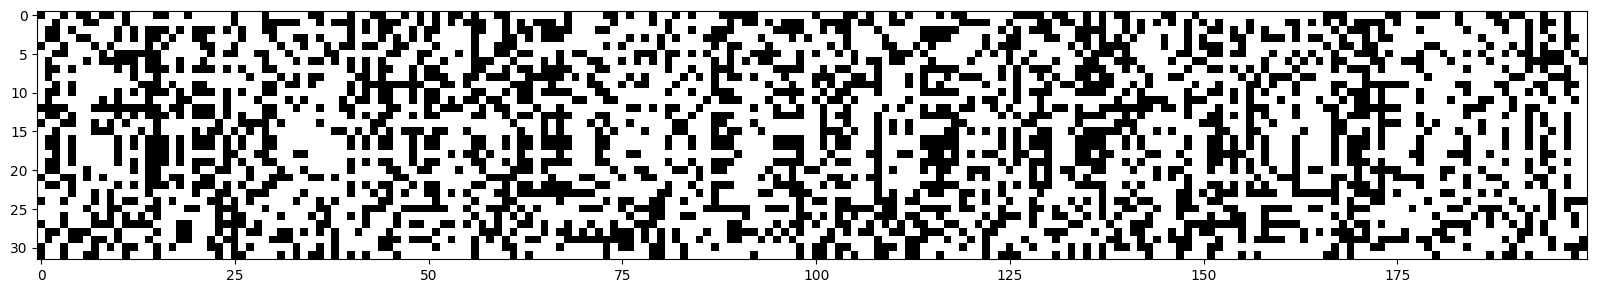

In [51]:
print((hidden_activation.abs() > 0.99).sum() / len(hidden_activation.flatten()))
plt.figure(figsize=(20, 10))
_ = plt.imshow(hidden_activation.abs() > 0.99, cmap="gray", interpolation="nearest")


Around 62% of the time tanh produces an output that has a very small gradient, so the gradient flowing backwards will get destroyed! This is a problem. (On the plot, white means true and black means false.) We have 200 neurons (columns). If all entries in a column were white (for all training samples), that neuron would be called a *dead neuron*, because it would learn extremely slowly -- it would basically not learn at all. In general, if all examples end up in a tail of the tanh, the neuron is dead, it will never learn. Here we can't find such a column, though: for every tanh neuron, we always have some examples that are activated in the active part of the tanh, so some gradients will flow through and the neuron will learn.
- Sigmoid, ReLU, ELU also have a dying neuron problem.
- If a neuron would not activate on any of the training samples using the ReLU activation, it would be a dead neuron. It would never learn anything throughout training. When can this happen? (1) At initialization. By chance, some neurons will stay forever dead. (2) During optimization. If we have a too high learning rate, sometimes the neuron will get a too large gradient and they will get knocked off the data manifold.

How to change this behavior? The ``hidden_pre_activation`` has a too large magnitude. We can, again, set b1 to zero, and to encourage small values, we can scale down ``W1``.

11897


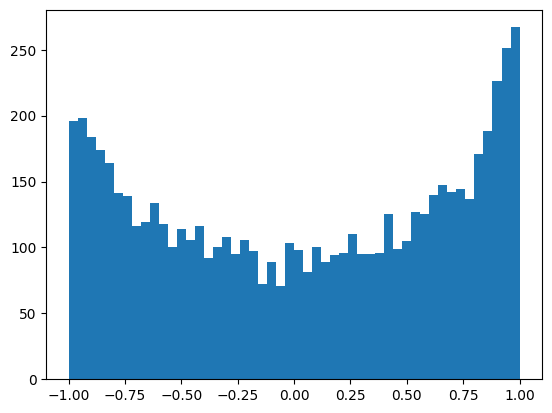

tensor(0.0177)


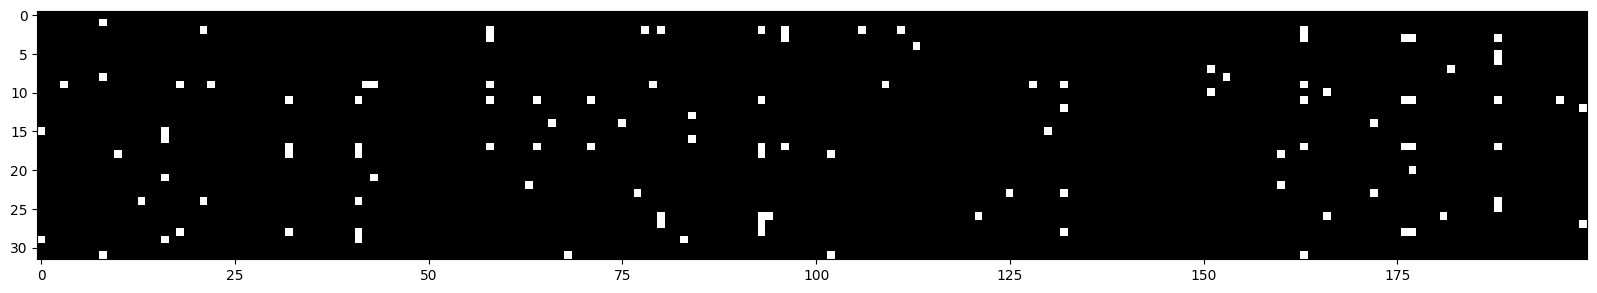

In [52]:
# MLP revisited
dim_embedding = 10
dim_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)
W1 = torch.randn(dim_embedding * block_size, dim_hidden, generator=g) * 0.2
b1 = torch.zeros(dim_hidden)
W2 = torch.randn(dim_hidden, num_tokens, generator=g) * 0.01
b2 = torch.zeros(num_tokens)

parameters = [C, W1, b1, W2, b2]
print(sum(parameter.nelement() for parameter in parameters))
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    embedding_cat = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    hidden_pre_activation = embedding_cat @ W1 + b1
    hidden_activation = torch.tanh(hidden_pre_activation)  # (32, dim_hidden)
    logits = hidden_activation @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    # if i % 50000 == 0:
    #     print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())  # Trends are easier to see, no huge changes

    break

plt.hist(hidden_activation.view(-1).detach().numpy(), bins=50)
plt.show()
print((hidden_activation.abs() > 0.99).sum() / len(hidden_activation.flatten()))
plt.figure(figsize=(20, 10))
_ = plt.imshow(hidden_activation.abs() > 0.99, cmap="gray", interpolation="nearest")


Much better, right? All neurons have small pre-activations on nearly all minibatch samples, so nearly all gradients are non-zero. Let's run the full optimization.

In [53]:
# MLP revisited
dim_embedding = 10
dim_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)
W1 = torch.randn(dim_embedding * block_size, dim_hidden, generator=g) * 0.2
b1 = torch.zeros(dim_hidden)
W2 = torch.randn(dim_hidden, num_tokens, generator=g) * 0.01
b2 = torch.zeros(num_tokens)

parameters = [C, W1, b1, W2, b2]
print(sum(parameter.nelement() for parameter in parameters))
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    embedding_cat = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    hidden_pre_activation = embedding_cat @ W1 + b1
    hidden_activation = torch.tanh(hidden_pre_activation)  # (32, dim_hidden)
    logits = hidden_activation @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    # if i % 50000 == 0:
    #     print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())  # Trends are easier to see, no huge changes


11897


In [54]:
@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    embedding = C[x]  # (N, block_size, dim_embedding)
    embedding_cat = embedding.flatten(start_dim=1)  # (N, block_size * dim_embedding)
    hidden_activation = torch.tanh(embedding_cat @ W1 + b1)  # (N, dim_hidden)
    logits = hidden_activation @ W2 + b2  # (N, num_tokens)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")


train 2.0345406532287598
val 2.104095697402954


This also squeezed out some performance. This is not surprising: with better initialiation, we don't have to (1) squash our weights before actual training, and (2) we also don't stop learning because of too small gradients from the get-go.

Note that we have a very shallow network here. Because of this, the optimization problem is quite easy and very forgiving. Even though our initialization was terrible, the network still learned reasonably well, it just got a bit worse results. This is not the case in general. For deeper networks, these problems stack up and we can get to scenarios where the network is not learning at all!

It's great that this worked for us, but we used many magic numbers (0.01, 0.2, etc.). How to initialize networks automatically, in a principled way?

tensor(-0.0022) tensor(0.9931)
tensor(0.0052) tensor(0.9796)


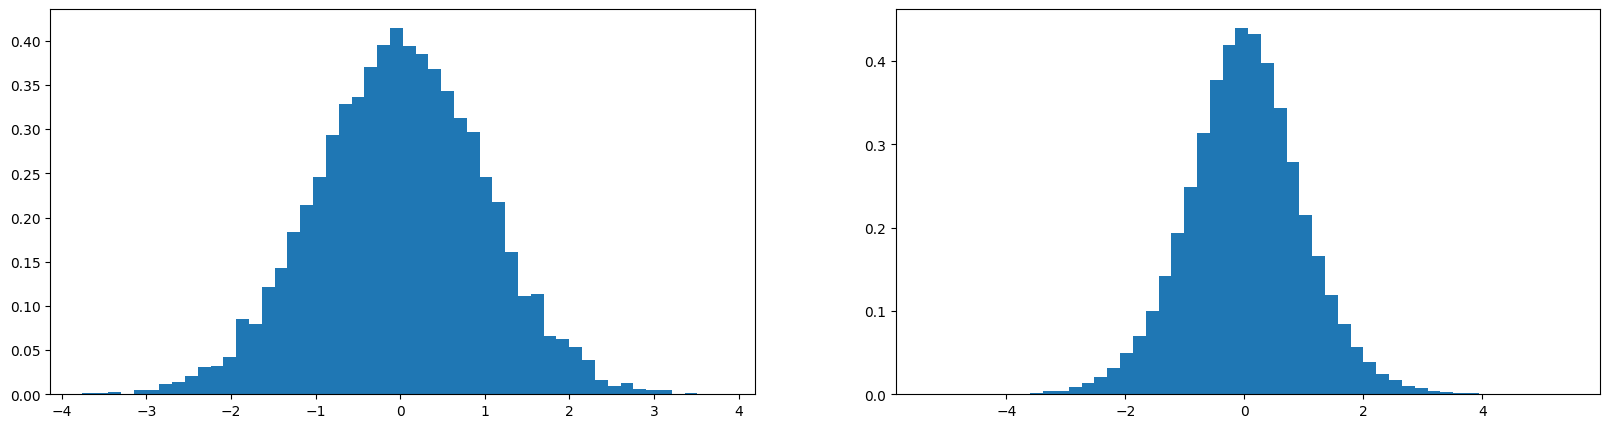

In [55]:
x = torch.randn(1000, 10)  # 1000 examples that are 10-dimensional
w = torch.randn(10, 200) / 10**0.5  # Weight layer of 200 neurons
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).numpy(), 50, density=True)
plt.subplot(122)
_ = plt.hist(y.view(-1).numpy(), 50, density=True)


The mean stays the same after the operation (as both operands come from a zero-centered Gaussian), but the std has expanded to 3! We don't want that. We want most of the NN to have relatively similar activations. How to scale ``w`` to let ``x @ w`` have the same distribution as ``x``? We, of course, have to multiply it by a number less than one and play with that number. The multiplicative factor of 0.3 seems to be giving good results. But what to multiply with to preserve the std exactly? It turns out that we have to divide the weight matrix by $$\sqrt{\text{fan\_in}}.$$

A number of papers looked into how to best initialize neural networks. We can have deep networks that have non-linearities in between, and we want to make sure that the activations are well-behaved. How to initialize the weights such that the activations take on reasonable values throughout the network (and it's a good starting point for training)? [This](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) paper answers this question.
- The ReLU is a squashing function. All negative numbers are simply clamped to 0.
- Because we are simply throwing away half of the distribution, they find in their analysis that we have to compensate for that with a gain of $\sqrt{\frac{2}{\text{fan\_in}}}$.
- The factor of 2 is added because of ReLU discarding half of the distribution.
- They find that if we properly initialize the forward pass, the backward pass is also approximately well-initialized (up to a constant factor that has to do with the number of hidden neurons in the layers -- they find empirically that this does not matter too much).
- In torch, a general form of this initialization is given by ``torch.nn.init.kaiming_normal_``.
    - ``mode``: Would you like to normalize the activations or the gradients to be always Gaussian with 0 mean and unit standard deviation? Because they find it in the paper that this doesn't matter too much, most people just leave it as the default mode which is ``fan_in``.
    - ``nonlinearity``: Depending on the nonlinearity, we need to calculate a slightly different gain. If it's linear, then the gain is one. If it's different, we're going to get a slightly different gain (for ReLU it's $\sqrt{2}$, for tanh it's $5/3$). Why do we even need a gain on top of the derived formula? Because tanh, just like ReLU, is a contractive transformation. We're taking the output distribution from the matrix multiplication and we are squashing it in some way. ReLU squashes it by setting non-zero values to zero. Tanh squashes it to the range -1, 1. In order to fight this "squeezing in", we need to boost the weights a little bit so that we normalize everything back to unit standard deviation.

We are skipping through this section rather quickly. This is because about 7 years ago (when the He et al. paper was written), we had to be extremely careful with the activations, gradients, ranges, histograms, the precise setting of gains, etc. Everything was very fragile and had to be very properly arranged for the NN to train properly, especially when it was very deep. Since then, there have been a number of modern innovations that have made everything significantly more stable and more well-behaved. It has become less important to initialize these networks exactly right. Some of these modern innovations:
- Residual connections
- Normalization techniques: batch normalization, layer normalization, group normalization, etc.
- Much better optimizers: RMSProp, Adam

All of these make it less important for us to precisely calibrate the initialization of the NN. In practice, it's enough to normalize the weights by $\sqrt{\text{fan\_in}}$. If we want to be exactly accurate, we can multiply by the gain depending on what activation we have.

In [56]:
(torch.randn(10000) * 0.2).std()


tensor(0.2004)

The number we multiply with ends up being the standard deviation of the Gaussian. For tanh, we would proceed as follows.

In [57]:
W = torch.randn(30, 10) * (5 / 3) / 30**0.5
print(W.std())
print((5 / 3) / 30**0.5)


tensor(0.2905)
0.3042903097250923


Let's put everything together so far.

In [58]:
# MLP revisited
dim_embedding = 10
dim_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)

# Kaiming init for tanh nonlinearity
W1 = (
    torch.randn(dim_embedding * block_size, dim_hidden, generator=g)
    * (5 / 3)
    / (dim_embedding * block_size) ** 0.5
)
b1 = torch.zeros(dim_hidden)
W2 = torch.randn(dim_hidden, num_tokens, generator=g) / (dim_hidden) ** 0.5
b2 = torch.zeros(num_tokens)

parameters = [C, W1, b1, W2, b2]
print(sum(parameter.nelement() for parameter in parameters))
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    embedding_cat = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    hidden_pre_activation = embedding_cat @ W1 + b1
    hidden_activation = torch.tanh(hidden_pre_activation)  # (32, dim_hidden)
    logits = hidden_activation @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    # if i % 50000 == 0:
    #     print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())  # Trends are easier to see, no huge changes


@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    embedding = C[x]  # (N, block_size, dim_embedding)
    embedding_cat = embedding.flatten(start_dim=1)  # (N, block_size * dim_embedding)
    hidden_activation = torch.tanh(embedding_cat @ W1 + b1)  # (N, dim_hidden)
    logits = hidden_activation @ W2 + b2  # (N, num_tokens)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")


11897
train 2.03794002532959
val 2.1061716079711914


This is almost exactly what we got previously after playing around with the weight scaling, but now we could simply use a formula to determine it. This method scales to much deeper networks too.

### Batch Normalization

The [paper](https://arxiv.org/abs/1502.03167) from 2015 was extremely impactful, because it made it possible to train very deep NNs quite reliably. We have the hidden state ``hidden_pre_activation``. We don't want these pre-activations to be way too small (tanh is not doing anything, it's just linear), but we also don't want them to be way too large (tanh is saturated, model doesn't learn). We want them to be roughly a standard Gaussian, at least at initialization. Insight from the BatchNorm paper:
- If we want the hidden states to be standard Gaussian anyways (at least at initialization), why don't we just normalize them to be standard Gaussian? Standardizing hidden states is perfectly differentiable.
- We want standard Gaussianity, but only at initialization. We don't want the pre-activations to be forced to be Gaussian *throughout training*. We want to allow neurons to move away from this as training progresses and saturate the activations for confidently correct predictions.
- As such, we don't only normalize, we also *scale and shift*.


Let's implement it.

In [59]:
# MLP revisited
dim_embedding = 10
dim_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)

# Kaiming init for tanh nonlinearity
W1 = (
    torch.randn(dim_embedding * block_size, dim_hidden, generator=g)
    * (5 / 3)
    / (dim_embedding * block_size) ** 0.5
)
b1 = torch.zeros(dim_hidden)
W2 = torch.randn(dim_hidden, num_tokens, generator=g) / (dim_hidden) ** 0.5
b2 = torch.zeros(num_tokens)

# At initialization, each neuron's pre-activations on the batch
# will be exactly standard Gaussian, no matter what the distribution
# of the pre-activation is *before* normalization.
# During optimization we optimize bn_gain and bn_bias to allow the network
# to transform the normalized pre-activations arbitrarily and fit the
# dataset well.
bn_gain = torch.ones((1, dim_hidden))
bn_bias = torch.zeros((1, dim_hidden))  # Same for all samples

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(parameter.nelement() for parameter in parameters))
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    embedding_cat = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    hidden_pre_activation = embedding_cat @ W1 + b1

    # Every single neuron's pre-activation will come from a standard Gaussian
    # on this batch of 32 samples
    hidden_pre_activation = (
        hidden_pre_activation - hidden_pre_activation.mean(dim=0, keepdim=True)
    ) / hidden_pre_activation.std(
        dim=0, keepdim=True
    )  # (32, dim_hidden)
    hidden_pre_activation = bn_gain * hidden_pre_activation + bn_bias

    hidden_activation = torch.tanh(hidden_pre_activation)  # (32, dim_hidden)
    logits = hidden_activation @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    # if i % 50000 == 0:
    #     print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())  # Trends are easier to see, no huge changes


@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    embedding = C[x]  # (N, block_size, dim_embedding)
    embedding_cat = embedding.flatten(start_dim=1)  # (N, block_size * dim_embedding)
    hidden_pre_activation = embedding_cat @ W1 + b1
    hidden_pre_activation = (
        hidden_pre_activation - hidden_pre_activation.mean(dim=0, keepdim=True)
    ) / hidden_pre_activation.std(
        dim=0, keepdim=True
    )  # (N, dim_hidden)
    hidden_pre_activation = bn_gain * hidden_pre_activation + bn_bias
    hidden_activation = torch.tanh(hidden_pre_activation)  # (N, dim_hidden)
    logits = hidden_activation @ W2 + b2  # (N, num_tokens)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")


12297
train 2.0687665939331055
val 2.108628511428833


The attained validation loss is almost the same as with only careful initialization. We're not expecting any improvement here, because we only have a very simple neural network with just a single hidden layer. Here, we could already initialize the weights such that we got roughly a standard Gaussian pre-activation -- Batch Normalization won't help much.

But once we have a much deeper neural network (e.g., with residual connections), it will be very hard to tune the scales of the weight matrices such that all activations through the neural net are roughly Gaussian. It's much easier to sprinkle Batch Normalization layers throughout the neural net. It's common to take all linear layers / convolutions and append a batch normalization layer right after it, to control the scale of activations at every point of the neural net. This also doesn't require us to do perfect maths and care about the pre-activation distributions for any possible transformation we want to introduce into our neural net. It stabilizes training by a lot.
- The stability offered by Batch Normalization actually comes at a seemingly large cost.
- Previously, for a single example we could calculate the output in a deterministic fashion. We used batches for training, but still, the outputs for samples inside the batch were independent.
- But now, because of the normalization on the batch dimension, we are coupling the examples in the same batch mathematically, in the forward and backward pass as well. The pre-activations and final logits are not just a function of the single input example anymore -- they are also a function of all other samples in the batch, *that are sampled randomly*. This means that if we change the other samples in the minibatch, we will get a slightly different output from the network for the single example.
- However,this jitter on the pre-activations and logits are, in a very strange way, very good for neural net training as a side-effect. This is because we can think of this noise as a regularizer -- it introduces a little bit of entropy (noise in the forward pass wrt. the mini-batch) and is effectively augmenting our samples with other samples. This makes it harder for the neural net to overfit to the single examples. This is why as a second-order effect, Batch Normalization is actually a regularizer, which has made it harder for us to stop using Batch Normalization. No one likes the property that the examples in the batch are coupled mathematically. It leads to strange results and bugs. This is why people have tried to deprecate the use of Batch Normalization and move to other normalization technique that don't couple the examples in the same mini-batch: **layer normalization, instance normalization, group normalization, etc.**

Long story short: Batch Normalization was the first normalization technique to be introduced. It worked extremely well, and it also happened to have a regularizing effect. It stabilized training, but came with the undesired coupling of samples, which made people want to go towards other regularization techniques. But it's been hard, because it works quite well (regularization, stability).

Weird outcome of coupling: once we trained a neural net, we would like to deploy it. We want to be able to feed in a **single example** and get the corresponding prediction. How can we do that if our neural net calculates the mean and standard deviation of a mini-batch in the forward pass to normalize? The neural net expects batches as an input now! How can we feed in a single example and get sensible results?
- Proposal in the Batch Normalization paper: we want to have a step after training that calculates and sets the Batch Normalization mean and standard deviation a single time over the entire training set:

In [60]:
# Calibrate Batch Normalization at the end of training:
with torch.no_grad():
    # Pass the entire training set through
    embedding = C[Xtr]
    embedding_cat = embedding.view(embedding.shape[0], -1)
    hidden_pre_activation = embedding_cat @ W1 + b1

    # Measure the mean/std over the entire training set
    bn_mean = hidden_pre_activation.mean(dim=0, keepdim=True)
    bn_std = hidden_pre_activation.std(dim=0, keepdim=True)

# We are going to use these fixed values during inference


@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    embedding = C[x]  # (N, block_size, dim_embedding)
    embedding_cat = embedding.flatten(start_dim=1)  # (N, block_size * dim_embedding)
    hidden_pre_activation = embedding_cat @ W1 + b1
    hidden_pre_activation = (
        hidden_pre_activation - bn_mean
    ) / bn_std  # (N, dim_hidden)
    hidden_pre_activation = bn_gain * hidden_pre_activation + bn_bias
    hidden_activation = torch.tanh(hidden_pre_activation)  # (N, dim_hidden)
    logits = hidden_activation @ W2 + b2  # (N, num_tokens)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")


train 2.0687665939331055
val 2.108649730682373


We basically get an identical result, but now we can forward a single example as well, as the batch statistics are fixed in deployment. This decouples the correlation among samples in deployment (but not in training).

However, no one wants to estimate the mean and standard deviation as a second stage after neural network training because everyone is lazy. Instead, we can estimate the mean and standard deviation during training, with an exponential moving average.

In [61]:
# MLP revisited
dim_embedding = 10
dim_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)

# Kaiming init for tanh nonlinearity
W1 = (
    torch.randn(dim_embedding * block_size, dim_hidden, generator=g)
    * (5 / 3)
    / (dim_embedding * block_size) ** 0.5
)  # torch.Linear initializes with a Uniform distribution, not a Normal one
b1 = torch.zeros(dim_hidden)
W2 = torch.randn(dim_hidden, num_tokens, generator=g) / (dim_hidden) ** 0.5
b2 = torch.zeros(num_tokens)

# At initialization, each neuron's pre-activations on the batch
# will be exactly standard Gaussian, no matter what the distribution
# of the pre-activation is *before* normalization.
# During optimization we optimize bn_gain and bn_bias to allow the network
# to transform the normalized pre-activations arbitrarily and fit the
# dataset well.
bn_gain = torch.ones((1, dim_hidden))
bn_bias = torch.zeros((1, dim_hidden))  # Same for all samples

# We initialize these with these values because after the initialization we
# know that hidden_pre_activation will be roughly a standard Gaussian,
# so we don't want to change that at the beginning of training.
bn_mean_running = torch.zeros((1, dim_hidden))
bn_std_running = torch.ones((1, dim_hidden))

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print(sum(parameter.nelement() for parameter in parameters))
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    embedding_cat = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    hidden_pre_activation = embedding_cat @ W1 + b1

    bn_mean_i = hidden_pre_activation.mean(dim=0, keepdim=True)
    bn_std_i = hidden_pre_activation.std(dim=0, keepdim=True)

    with torch.no_grad():
        # In BatchNorm1d the momentum is 0.1.
        # If we have a very large batch size, we can use higher momentum.
        # For batch_size 32, the mean and std wiggle a lot, so we need a lower momentum.
        # (With a higher one, we wouldn't converge to the mean and std of the entire dataset.)
        # track_running_stats determines whether we want to do what we do below,
        # or we want to estimate mean and std post-hoc.
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i

    hidden_pre_activation = (
        hidden_pre_activation - bn_mean_i
    ) / bn_std_i  # (32, dim_hidden)
    hidden_pre_activation = bn_gain * hidden_pre_activation + bn_bias

    hidden_activation = torch.tanh(hidden_pre_activation)  # (32, dim_hidden)
    logits = hidden_activation @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    # if i % 50000 == 0:
    #     print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())  # Trends are easier to see, no huge changes


@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    embedding = C[x]  # (N, block_size, dim_embedding)
    embedding_cat = embedding.flatten(start_dim=1)  # (N, block_size * dim_embedding)
    hidden_pre_activation = embedding_cat @ W1 + b1
    hidden_pre_activation = (
        hidden_pre_activation - bn_mean_running
    ) / bn_std_running  # (N, dim_hidden)
    hidden_pre_activation = bn_gain * hidden_pre_activation + bn_bias
    hidden_activation = torch.tanh(hidden_pre_activation)  # (N, dim_hidden)
    logits = hidden_activation @ W2 + b2  # (N, num_tokens)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")


12297
train 2.0684926509857178
val 2.108814239501953


We can see roughly equal results.

In [62]:
# Calibrate Batch Normalization at the end of training:
with torch.no_grad():
    # Pass the entire training set through
    embedding = C[Xtr]
    embedding_cat = embedding.view(embedding.shape[0], -1)
    hidden_pre_activation = embedding_cat @ W1 + b1

    # Measure the mean/std over the entire training set
    bn_mean = hidden_pre_activation.mean(dim=0, keepdim=True)
    bn_std = hidden_pre_activation.std(dim=0, keepdim=True)


In [63]:
bn_mean[0, :10]


tensor([-1.8117, -0.8684, -1.6617,  0.7387,  0.7530, -0.1670,  1.9126, -1.8388,
         0.3233,  1.2963])

In [64]:
bn_mean_running[0, :10]


tensor([-1.8049, -0.8620, -1.6614,  0.7436,  0.7589, -0.1869,  1.9005, -1.8471,
         0.3203,  1.2907])

In [65]:
bn_std[0, :10]


tensor([2.2486, 1.8480, 2.1030, 2.1766, 2.0328, 2.2415, 2.2018, 2.3622, 1.9962,
        1.8660])

In [66]:
bn_std_running[0, :10]


tensor([2.2216, 1.8098, 2.0723, 2.1426, 2.0080, 2.2131, 2.1808, 2.3287, 1.9811,
        1.8369])

The running mean and std closely resemble the actual mean and std across the dataset. This eliminates the need for explicit calibration after training, because we are doing it during training.

Note that b1 becomes useless in the network. We always subtract the mean, so the value of b1 does not affect the loss -- it never learns anything. We can simply get rid of it. The ``bn_bias`` is in charge of the biasing of the distribution -- Batch Normalization has its own bias, and there is no need to have a bias in the layer before.

In [67]:
# MLP revisited
dim_embedding = 10
dim_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(num_tokens, dim_embedding, generator=g)

# Kaiming init for tanh nonlinearity
W1 = (
    torch.randn(dim_embedding * block_size, dim_hidden, generator=g)
    * (5 / 3)
    / (dim_embedding * block_size) ** 0.5
)
W2 = torch.randn(dim_hidden, num_tokens, generator=g) / (dim_hidden) ** 0.5
b2 = torch.zeros(num_tokens)

bn_gain = torch.ones((1, dim_hidden))
bn_bias = torch.zeros((1, dim_hidden))  # Same for all samples

bn_mean_running = torch.zeros((1, dim_hidden))
bn_std_running = torch.ones((1, dim_hidden))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(parameter.nelement() for parameter in parameters))
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    embedding_cat = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    hidden_pre_activation = embedding_cat @ W1

    bn_mean_i = hidden_pre_activation.mean(dim=0, keepdim=True)
    bn_std_i = hidden_pre_activation.std(dim=0, keepdim=True)

    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i

    hidden_pre_activation = (
        hidden_pre_activation - bn_mean_i
    ) / bn_std_i  # (32, dim_hidden)
    hidden_pre_activation = bn_gain * hidden_pre_activation + bn_bias

    hidden_activation = torch.tanh(hidden_pre_activation)  # (32, dim_hidden)
    logits = hidden_activation @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    # if i % 50000 == 0:
    #     print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())  # Trends are easier to see, no huge changes


@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    embedding = C[x]  # (N, block_size, dim_embedding)
    embedding_cat = embedding.flatten(start_dim=1)  # (N, block_size * dim_embedding)
    hidden_pre_activation = embedding_cat @ W1
    hidden_pre_activation = (
        hidden_pre_activation - bn_mean_running
    ) / bn_std_running  # (N, dim_hidden)
    hidden_pre_activation = bn_gain * hidden_pre_activation + bn_bias
    hidden_activation = torch.tanh(hidden_pre_activation)  # (N, dim_hidden)
    logits = hidden_activation @ W2 + b2  # (N, num_tokens)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")


12097
train 2.0684926509857178
val 2.108814001083374


We always place Batch Normalization after a layer that has multiplication, e.g., a linear layer or a convolutional layer. Note that no one really likes this layer -- we should avoid it as much as possible. Other alternatives are group normalization or layer normalization. But it was still influential at the time, because it allowed reliable training of very deep neural nets. For optimization of RNNs, many of the techniques introduced in this notebook will become very important, as these are very deep networks (once we unroll them).

Real example: ResNet-50. It has many-many layers (with a repeating structure) -- conv (bias=false), batch_norm, relu.

Let's PyTorch-ify our code.

In [118]:
# Let's train a deeper network
class Linear:
    def __init__(
        self,
        fan_in: int,
        fan_out: int,
        bias: bool = True,
        generator: Optional[Generator] = None,
    ) -> None:
        self.weight = torch.randn(fan_in, fan_out, generator=generator) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: Tensor) -> Tensor:
        self.out = x @ self.weight  # Saved for visualization later
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self) -> list[Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Statistics (trained with a running momentum update)
        # These are called buffers in PyTorch nomenclature
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: Tensor) -> Tensor:
        # Forward pass
        if self.training:
            x_mean = x.mean(dim=0, keepdim=True)  # Batch mean
            x_var = x.var(dim=0, keepdim=True)  # Batch variance
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        x_hat = (x - x_mean) / (x_var + self.eps).sqrt()  # Normalize to unit variance
        self.out = self.gamma * x_hat + self.beta  # Saved for visualization later

        # Update statistics
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * x_mean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * x_var

        return self.out
    
    def parameters(self) -> list[Tensor]:
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x: Tensor) -> Tensor:
        self.out = torch.tanh(x)  # Saved for visualization later

        return self.out

    def parameters(self) -> list[Tensor]:
        return []


46497
      0/200000: 3.2960
Layer 1 (Tanh): mean -0.01, std 0.41, saturated: 0.00%
Layer 3 (Tanh): mean -0.00, std 0.20, saturated: 0.00%
Layer 5 (Tanh): mean +0.00, std 0.10, saturated: 0.00%
Layer 7 (Tanh): mean +0.00, std 0.05, saturated: 0.00%
Layer 9 (Tanh): mean -0.00, std 0.02, saturated: 0.00%


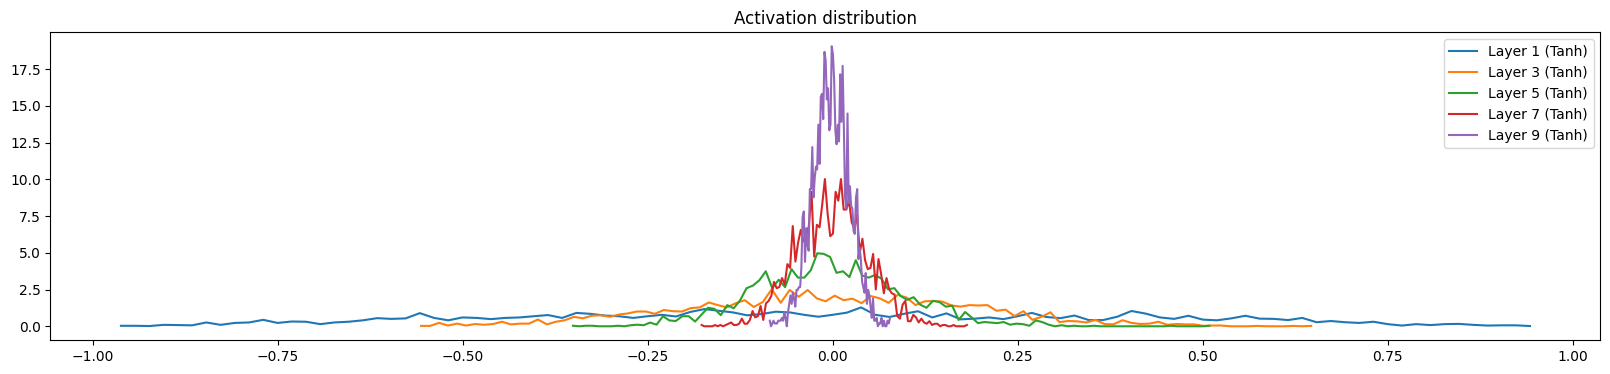

In [105]:
dim_embedding = 10
dim_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(num_tokens, dim_embedding, generator=g)
layers = [
    Linear(dim_embedding * block_size, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, num_tokens, generator=g),
]

with torch.no_grad():
    # Last layer: make less confident
    layers[-1].weight *= 0.1
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.5

parameters = [C] + [parameter for layer in layers for parameter in layer.parameters()]
print(
    sum(parameter.nelement() for parameter in parameters)
)  # Total number of parameters
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    x = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()  # Allows population of grad attribute for non-leaf tensors

    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break

# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude output layer
    if isinstance(layer, Tanh):
        tanh_out = layer.out
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean "
            f"{tanh_out.mean():+.2f}, std {tanh_out.std():.2f}, "
            f"saturated: {(tanh_out.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(tanh_out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
_ = plt.title("Activation distribution")


If we use a gain of 0.5, everything is all over the place. The standard deviation is shrinking and the saturation is zero everywhere. The first layer is pretty decent, but further layers are shrinking down to zero. This is a problem, because around that region, the tanh is roughly. When we have a sandwich of linear layers alone, then initializing our weights with $1 / sqrt{\text{fan\_in}}$ would have conserved std = 1 throughout the layers. However, tanh squashes the activations. They squash the output distribution, and therefore some gain is necessary to fight this squashing. If we don't multiply by any gain, everything just collapses to zero.

Layer 1 (Tanh): mean +0.000000, std 1.892402e-05
Layer 3 (Tanh): mean -0.000001, std 3.943546e-05
Layer 5 (Tanh): mean +0.000004, std 8.035369e-05
Layer 7 (Tanh): mean +0.000009, std 1.561152e-04
Layer 9 (Tanh): mean -0.000014, std 3.053498e-04


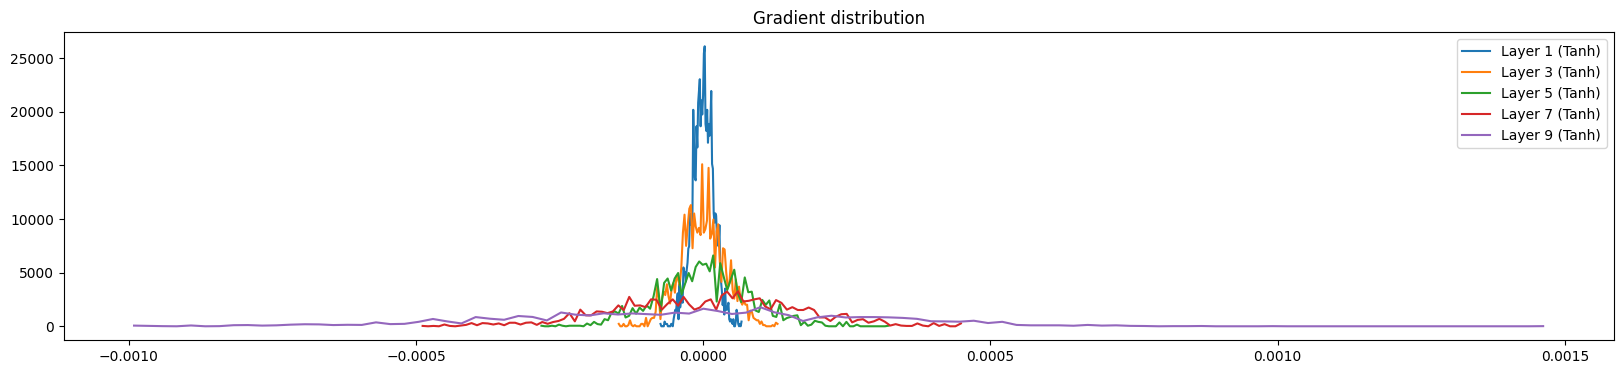

In [106]:
# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude output layer
    if isinstance(layer, Tanh):
        tanh_out_grad = layer.out.grad
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean {tanh_out_grad.mean():+f}, std {tanh_out_grad.std():e}"
        )
        hy, hx = torch.histogram(tanh_out_grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
_ = plt.title("Gradient distribution")


The gradients are also weird: as we go towards earlier layers, the gradients basically vanish: the distribution is more and more concentrated at zero.

46497
      0/200000: 3.2801
Layer 1 (Tanh): mean -0.03, std 0.85, saturated: 47.66%
Layer 3 (Tanh): mean +0.00, std 0.84, saturated: 40.47%
Layer 5 (Tanh): mean -0.01, std 0.84, saturated: 42.38%
Layer 7 (Tanh): mean -0.01, std 0.84, saturated: 42.00%
Layer 9 (Tanh): mean -0.03, std 0.84, saturated: 42.41%


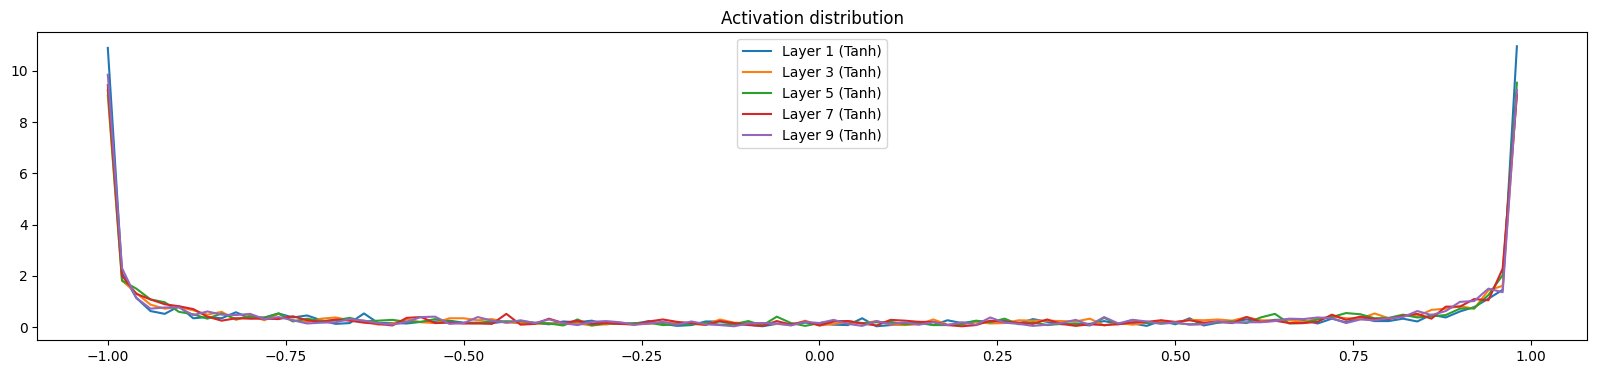

In [107]:
dim_embedding = 10
dim_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(num_tokens, dim_embedding, generator=g)
layers = [
    Linear(dim_embedding * block_size, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, num_tokens, generator=g),
]

with torch.no_grad():
    # Last layer: make less confident
    layers[-1].weight *= 0.1
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 3

parameters = [C] + [parameter for layer in layers for parameter in layer.parameters()]
print(
    sum(parameter.nelement() for parameter in parameters)
)  # Total number of parameters
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    x = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()  # Allows population of grad attribute for non-leaf tensors

    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break

# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude output layer
    if isinstance(layer, Tanh):
        tanh_out = layer.out
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean "
            f"{tanh_out.mean():+.2f}, std {tanh_out.std():.2f}, "
            f"saturated: {(tanh_out.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(tanh_out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
_ = plt.title("Activation distribution")


Layer 1 (Tanh): mean -0.000001, std 9.977492e-04
Layer 3 (Tanh): mean +0.000010, std 7.421207e-04
Layer 5 (Tanh): mean +0.000003, std 5.569781e-04
Layer 7 (Tanh): mean +0.000017, std 3.952166e-04
Layer 9 (Tanh): mean -0.000014, std 3.051525e-04


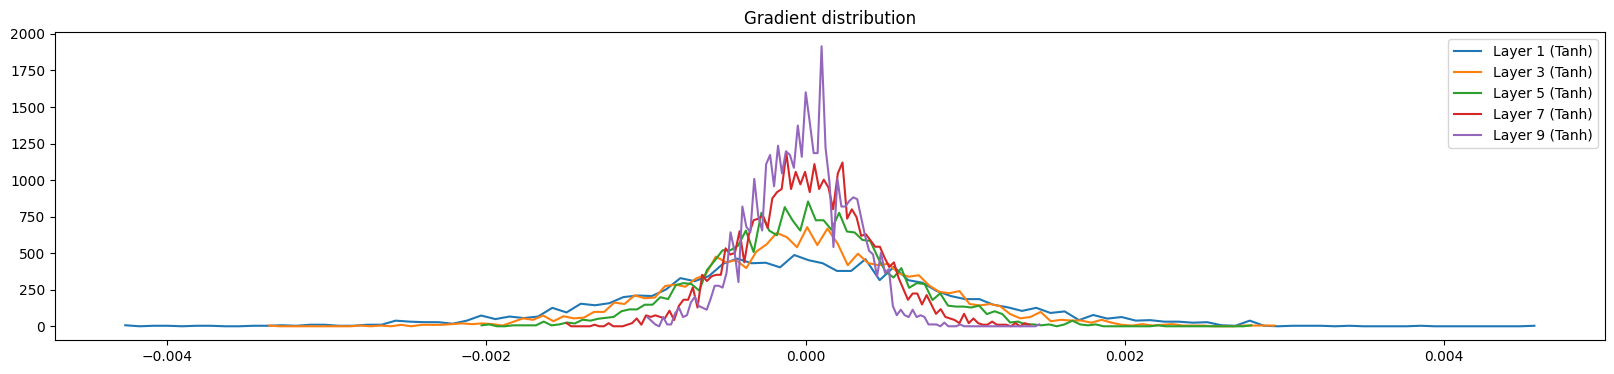

In [108]:
# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude output layer
    if isinstance(layer, Tanh):
        tanh_out_grad = layer.out.grad
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean {tanh_out_grad.mean():+f}, std {tanh_out_grad.std():e}"
        )
        hy, hx = torch.histogram(tanh_out_grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
_ = plt.title("Gradient distribution")


Here we see that the gradients are usually very small for later layers, and they are only reasonable for earlier ones. This also harms training. We are aiming to have the same distribution in each layer, both for activations and gradients.

If we now multiply by a gain of three, the saturation is way too large. 5 / 3 is a good setting, as can be seen below.

46497
      0/200000: 3.2962
Layer 1 (Tanh): mean -0.04, std 0.76, saturated: 21.97%
Layer 3 (Tanh): mean -0.01, std 0.72, saturated: 11.00%
Layer 5 (Tanh): mean +0.01, std 0.73, saturated: 13.00%
Layer 7 (Tanh): mean -0.05, std 0.73, saturated: 13.34%
Layer 9 (Tanh): mean +0.00, std 0.72, saturated: 10.53%


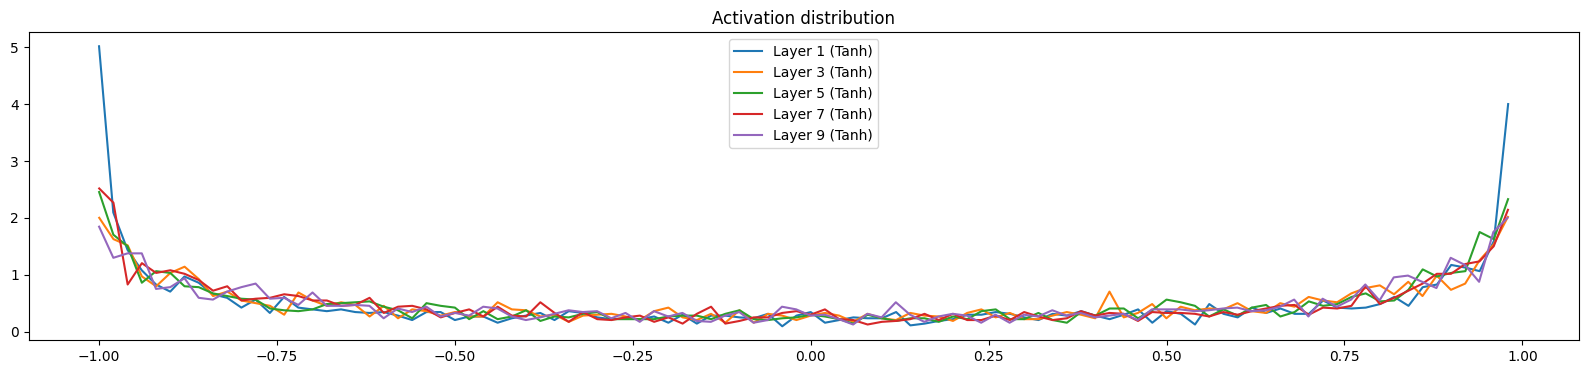

In [113]:
dim_embedding = 10
dim_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(num_tokens, dim_embedding, generator=g)
layers = [
    Linear(dim_embedding * block_size, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    Tanh(),
    Linear(dim_hidden, num_tokens, generator=g),
]

with torch.no_grad():
    # Last layer: make less confident
    layers[-1].weight *= 0.1
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [parameter for layer in layers for parameter in layer.parameters()]
print(
    sum(parameter.nelement() for parameter in parameters)
)  # Total number of parameters
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    x = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()  # Allows population of grad attribute for non-leaf tensors

    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        update_to_data_ratio.append(
            [
                (learning_rate * parameter.grad.std() / parameter.data.std())
                .log10()  # To get a nicer visualization
                .item()
                for parameter in parameters
            ]
        )

    # break

    if i >= 1000:
        break

# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude output layer
    if isinstance(layer, Tanh):
        tanh_out = layer.out
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean "
            f"{tanh_out.mean():+.2f}, std {tanh_out.std():.2f}, "
            f"saturated: {(tanh_out.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(tanh_out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
_ = plt.title("Activation distribution")


The first layer is fairly saturated, but the saturation stabilizes as we go into deeper layers. If we had more layers, we would stabilize around std 0.65 and the saturation would be roughly 5%. The reason for the stabilization is that the gain is set to 5/3. This is crucial. Interestingly, Andrej hasn't found anything about where this 5/3 is coming from. Empirically, it seems to work.

Layer 1 (Tanh): mean +0.000024, std 3.353990e-03
Layer 3 (Tanh): mean +0.000012, std 3.157343e-03
Layer 5 (Tanh): mean -0.000004, std 2.925862e-03
Layer 7 (Tanh): mean +0.000036, std 2.715700e-03
Layer 9 (Tanh): mean +0.000020, std 2.308167e-03


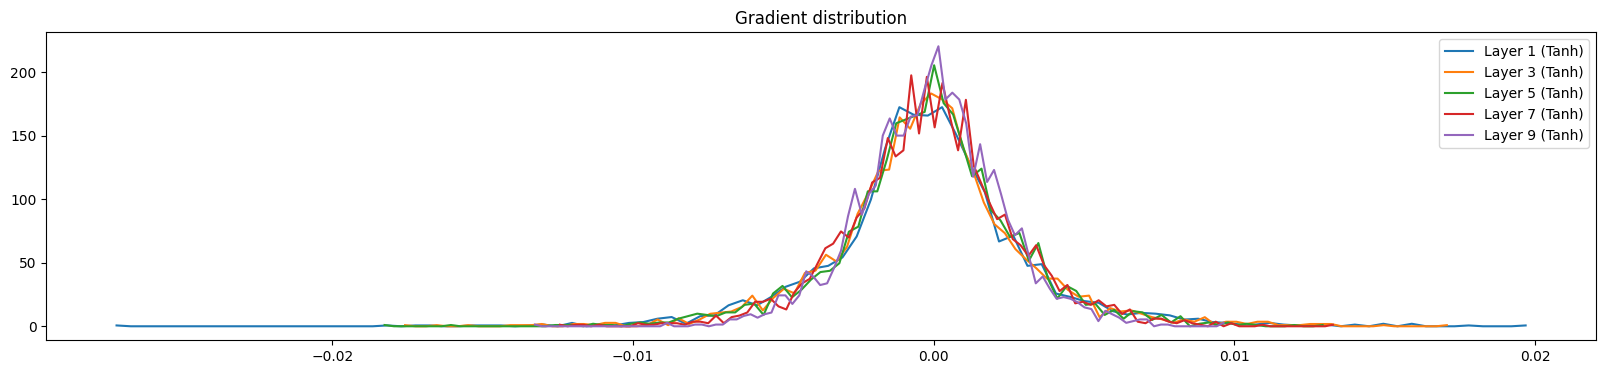

In [114]:
# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude output layer
    if isinstance(layer, Tanh):
        tanh_out_grad = layer.out.grad
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean {tanh_out_grad.mean():+f}, std {tanh_out_grad.std():e}"
        )
        hy, hx = torch.histogram(tanh_out_grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
_ = plt.title("Gradient distribution")


The gradient distribution is also fairly reasonable. In particular, all layers in our network have roughly the same gradient distribution. It doesn't shrink nor explode.

Without Batch Normalization, we very carefully have to set the gains to get a good starting point for our network (i.e., to get nice initial activation and gradient distributions). Getting neural nets to train before Batch Normalization, Adam, residual connections, etc. was painful and required careful engineering.

Note: there are entire papers that analyze how the training of linear networks with gradient descent is influenced by varying the number of linear layers (which still give rise to a single linear layer, but the training dynamics are very different). Some even consider infinitely many linear layers.

Weight   (27, 10) | mean +0.000980 | std 1.189170e-02 | grad/data std ratio 1.189148e-02
Weight  (30, 100) | mean +0.000118 | std 1.005290e-02 | grad/data std ratio 3.214553e-02
Weight (100, 100) | mean +0.000033 | std 7.821209e-03 | grad/data std ratio 4.653360e-02
Weight (100, 100) | mean -0.000107 | std 6.655618e-03 | grad/data std ratio 3.925850e-02
Weight (100, 100) | mean -0.000017 | std 6.086039e-03 | grad/data std ratio 3.605767e-02
Weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad/data std ratio 3.015269e-02
Weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad/data std ratio 2.909911e-01


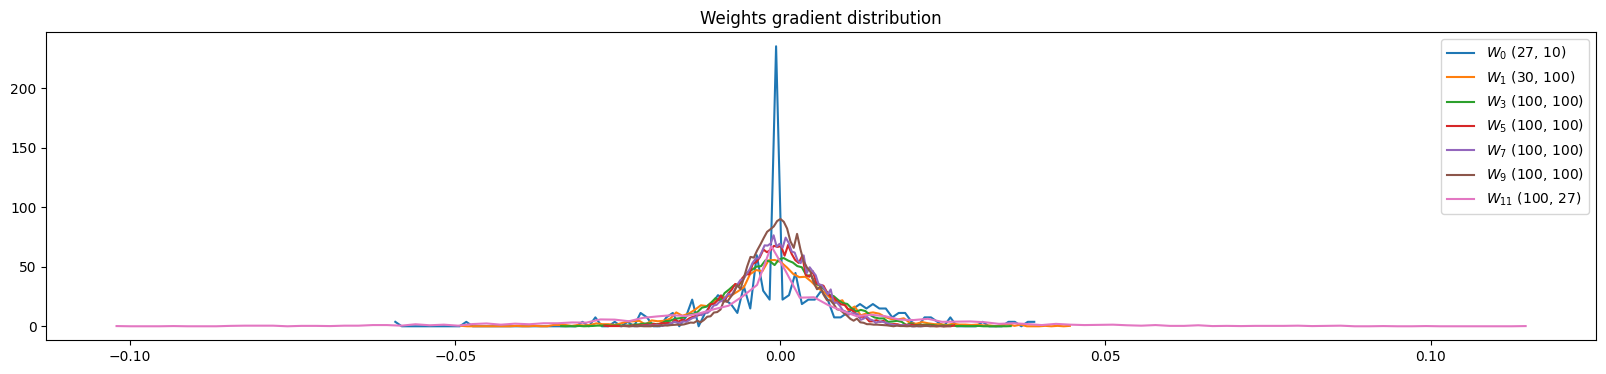

In [115]:
# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, parameter in enumerate(parameters):
    if parameter.ndim == 2:  # Weight matrix
        print(
            f"Weight {str(tuple(parameter.shape)):>10} "
            f"| mean {parameter.grad.mean():+f} "
            f"| std {parameter.grad.std():e} "
            f"| grad/data std ratio {parameter.grad.std() / parameter.data.std():e}"
        )
        hy, hx = torch.histogram(parameter.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(rf"$W_{ {i} }$ {tuple(parameter.shape)}")
plt.legend(legends)
_ = plt.title("Weights gradient distribution")


Even though the previous plots looked nice, it seems that there is still some trouble in paradise.

The gradient to data ratio gives a sense of what the scale of the gradient is compared to the scale of the actual values. This is important, because we are going to take a step update that is $\text{learning\_rate} \times \text{gradient}$ *with the data*. If the gradient's magnitude is too large compared to the data values, we are in trouble. In this case, the ratios are quite low, indicating that the values inside grad are much smaller than the values inside data (except for the last weight matrix). The output layer is a bit of a trouble maker in the way it's currently arranged. This is because the last layer (in pink) takes on values that are much larger than some of the hidden weights. The last layer's standard deviation is also much larger than the rest's. We would be training this layer around 10-100x faster than the other layers using standard SGD.

One can check, however, that this sort of fixes itself after a little bit of training by changing the break statement above.. The tails of the last pink layer are coming in during the optimization.

We check one last plot that Andrej likes to look at when training neural networks. The gradient to data ratio is actually not that informative. What matters in the end is the *update* to data ratio, as that also includes the learning rate. That is the amount by which we will actually change the data in the tensors.

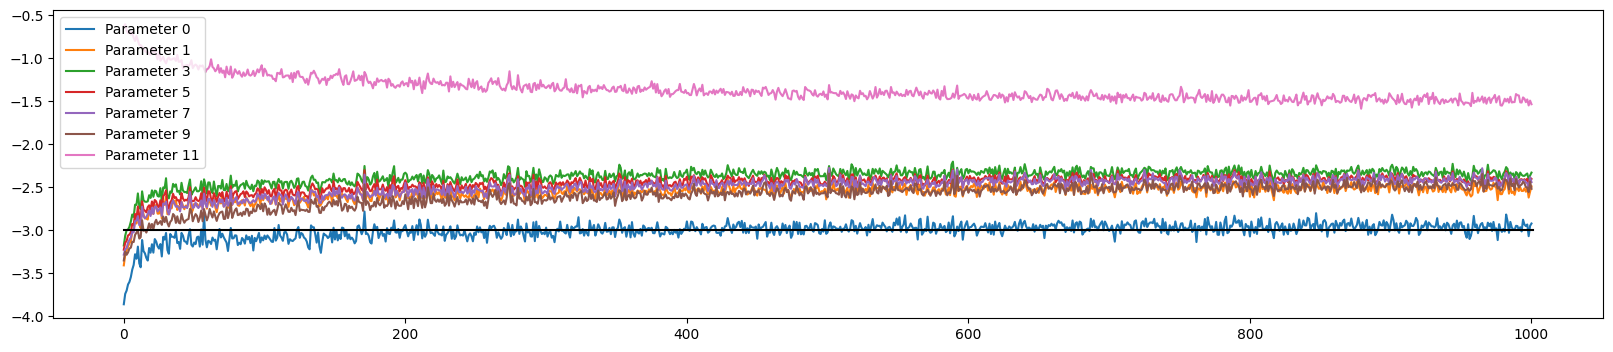

In [116]:
plt.figure(figsize=(20, 4))
legends = []
for i, parameter in enumerate(parameters):
    if parameter.ndim == 2:
        plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
        legends.append(f"Parameter {i}")
plt.plot([0, len(update_to_data_ratio)], [-3, -3], "k")  # These ratios should be ~1e-3, indicate on plot
_ = plt.legend(legends)

This is a plot of the update ratios over time for each weight matrix. During the first couple of steps there is a larger increase in the ratio, but it stabilizes throughout training. The ratio should be roughly 1e-3. That means that the spread of the updates to each parameter should be no larger than a 1000th of the spread of the parameters themselves. We want to make sure that during the training procedure, the ratio doesn't go too much above or below 1e-3 for any parameter. (Below means that the parameters are not training fast enough.) A too small learning rate can be easily detected, and we can set the learning rate roughly well using this technique. Here the learning rate is a bit on the larger side, but it's ok, as everything is nicely stabilizing. When things are miscalibrated, we can see it very quickly.

The final layer is clearly an outlier. This is because this layer was artificially shrunk down to keep the softmax unconfident (multiply by 0.1). This made the values in the tensor way too low, and that's why we are getting a temporarily quite high ratio. We can see that this stabilizes over time, once the layer starts learning.

For a linear-tanh sandwich, we can precisely calibrate the gains and make the activations, gradients, parameters, updates all look pretty decent. But it is simply too much engineering, as the gain has to be precisely calibrated. Whenever we have a new architecture / new activation, we would always have to hand-engineer the gain or come up with some convincing maths.

Let's simply introduce batch norm and see how things change.

47551
      0/200000: 3.2870
Layer 2 (Tanh): mean -0.00, std 0.63, saturated: 2.62%
Layer 5 (Tanh): mean +0.00, std 0.64, saturated: 2.47%
Layer 8 (Tanh): mean -0.00, std 0.64, saturated: 2.16%
Layer 11 (Tanh): mean +0.00, std 0.65, saturated: 1.81%
Layer 14 (Tanh): mean -0.00, std 0.65, saturated: 1.78%


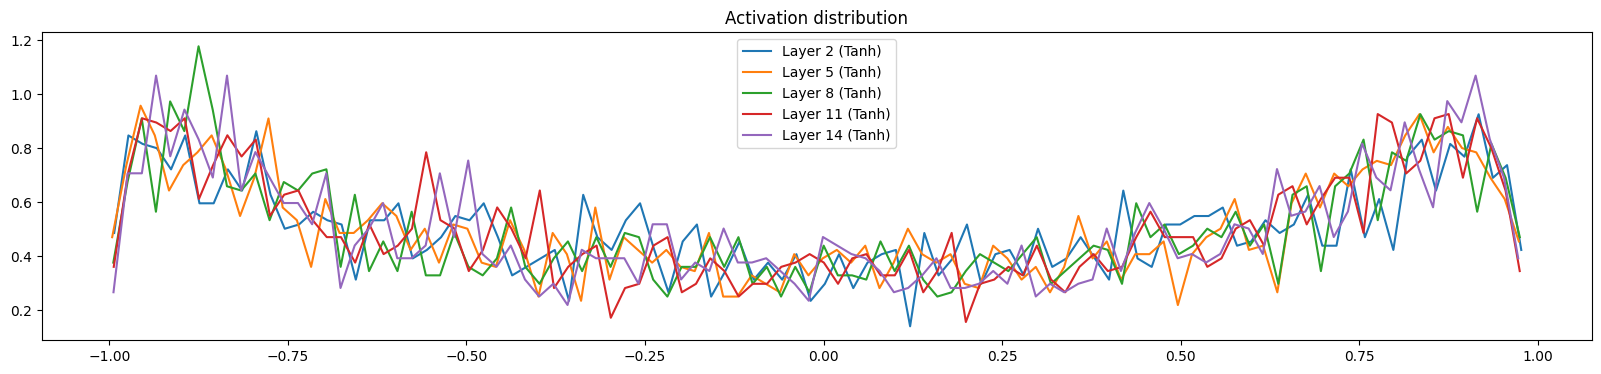

Layer 2 (Tanh): mean +0.000000, std 3.682946e-03
Layer 5 (Tanh): mean -0.000000, std 3.262604e-03
Layer 8 (Tanh): mean +0.000000, std 2.973726e-03
Layer 11 (Tanh): mean +0.000000, std 2.741104e-03
Layer 14 (Tanh): mean +0.000000, std 2.584291e-03


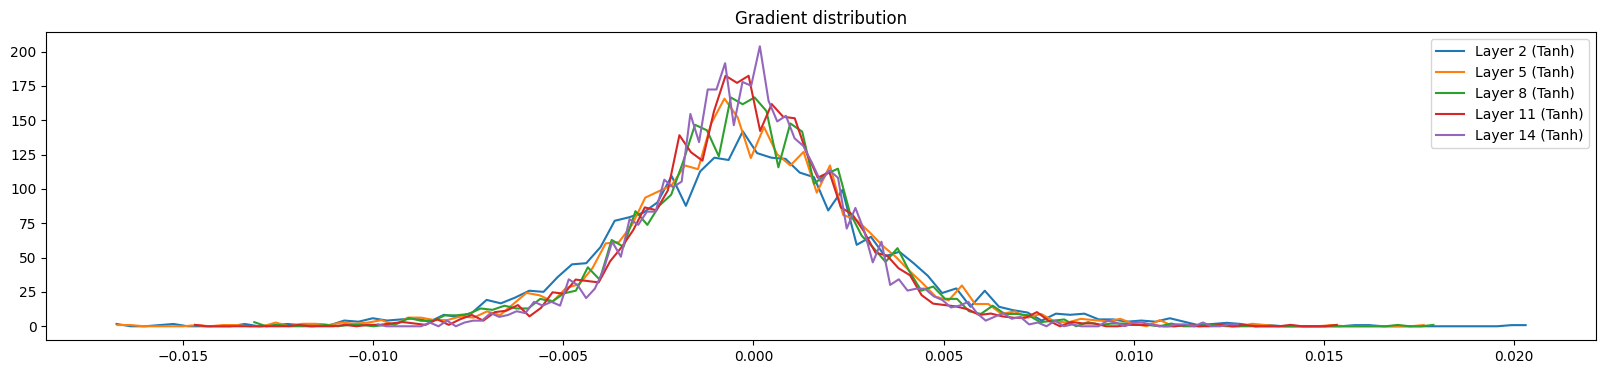

Weight   (27, 10) | mean -0.000000 | std 1.019881e-02 | grad/data std ratio 1.018842e-02
Weight  (30, 100) | mean +0.000092 | std 8.238411e-03 | grad/data std ratio 2.635833e-02
Weight (100, 100) | mean +0.000031 | std 7.318093e-03 | grad/data std ratio 4.377133e-02
Weight (100, 100) | mean -0.000019 | std 6.662015e-03 | grad/data std ratio 3.949891e-02
Weight (100, 100) | mean -0.000019 | std 5.821510e-03 | grad/data std ratio 3.468157e-02
Weight (100, 100) | mean +0.000053 | std 5.445287e-03 | grad/data std ratio 3.243362e-02
Weight  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad/data std ratio 6.281252e-02


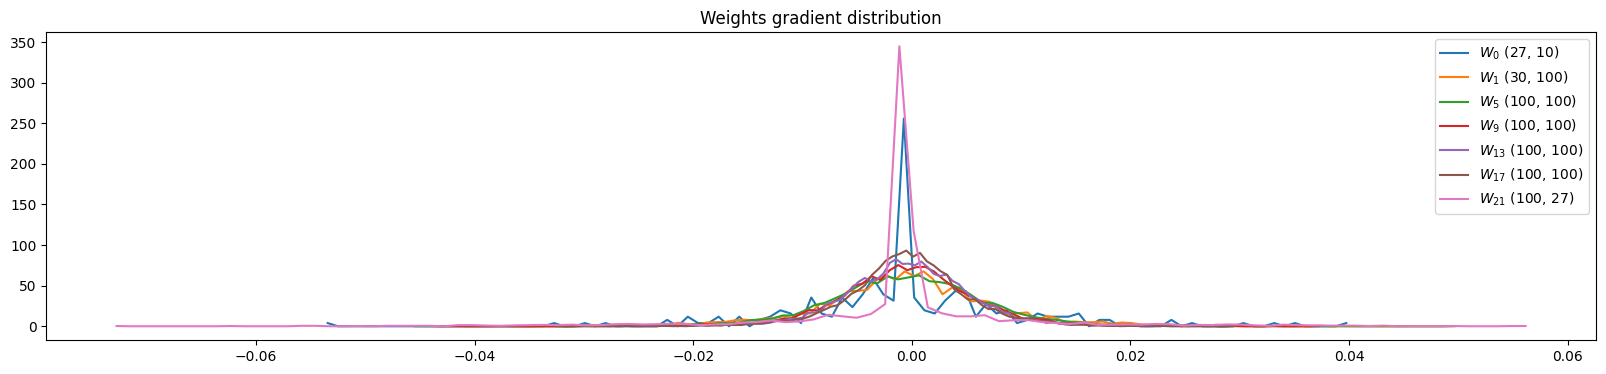

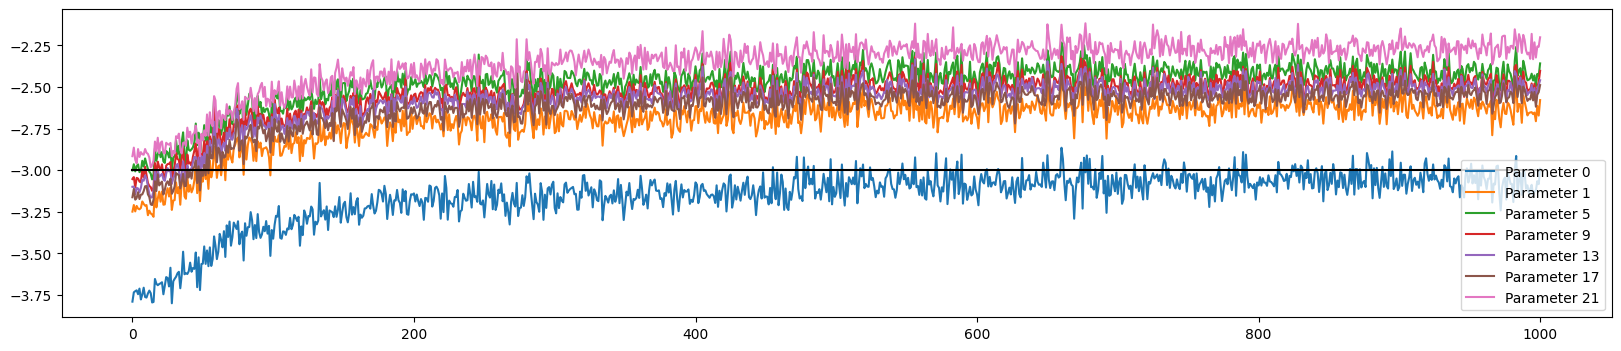

In [119]:
dim_embedding = 10
dim_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(num_tokens, dim_embedding, generator=g)
layers = [
    Linear(dim_embedding * block_size, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, num_tokens, generator=g),
    BatchNorm1d(num_tokens),  # This is also totally fine
]

with torch.no_grad():
    # We don't change the last layer to make the
    # weight less confident, as the last layer
    # has batch norm. Scaling the weight
    # would have no effect at all.
    # To this end, we rather have to change
    # the gamma parameter. This influences
    # the spread of the pre-activations of
    # the last layer.
    layers[-1].gamma *= 0.1
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [parameter for layer in layers for parameter in layer.parameters()]
print(
    sum(parameter.nelement() for parameter in parameters)
)  # Total number of parameters
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    x = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()  # Allows population of grad attribute for non-leaf tensors

    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 100000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        update_to_data_ratio.append(
            [
                (learning_rate * parameter.grad.std() / parameter.data.std())
                .log10()  # To get a nicer visualization
                .item()
                for parameter in parameters
            ]
        )

    # break

    if i >= 1000:
        break

# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude output layer
    if isinstance(layer, Tanh):
        tanh_out = layer.out
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean "
            f"{tanh_out.mean():+.2f}, std {tanh_out.std():.2f}, "
            f"saturated: {(tanh_out.abs() > 0.97).float().mean() * 100:.2f}%"
        )
        hy, hx = torch.histogram(tanh_out, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
_ = plt.title("Activation distribution")
plt.show()

# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):  # Exclude output layer
    if isinstance(layer, Tanh):
        tanh_out_grad = layer.out.grad
        print(
            f"Layer {i} ({layer.__class__.__name__}): mean {tanh_out_grad.mean():+f}, std {tanh_out_grad.std():e}"
        )
        hy, hx = torch.histogram(tanh_out_grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
_ = plt.title("Gradient distribution")
plt.show()

# Visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i, parameter in enumerate(parameters):
    if parameter.ndim == 2:  # Weight matrix
        print(
            f"Weight {str(tuple(parameter.shape)):>10} "
            f"| mean {parameter.grad.mean():+f} "
            f"| std {parameter.grad.std():e} "
            f"| grad/data std ratio {parameter.grad.std() / parameter.data.std():e}"
        )
        hy, hx = torch.histogram(parameter.grad, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(rf"$W_{ {i} }$ {tuple(parameter.shape)}")
plt.legend(legends)
_ = plt.title("Weights gradient distribution")
plt.show()

plt.figure(figsize=(20, 4))
legends = []
for i, parameter in enumerate(parameters):
    if parameter.ndim == 2:
        plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
        legends.append(f"Parameter {i}")
plt.plot([0, len(update_to_data_ratio)], [-3, -3], "k")  # These ratios should be ~1e-3, indicate on plot
_ = plt.legend(legends)

The activations, gradients, weights, updates look really good. Necessarily so, because before every single tanh layer we normalize to a standard Gaussian. Everything looks very homogeneous. In the updates, we are going above 1e-3 a little bit, but not by too much. All parameters are training at roughly the same rate.

What we gained: we are also less brittle to the gain parameter we specify. This is because of the explicit normalization. Whatever (sensible) gain we choose, we get nearly the same distributions. Often we don't even have to normalize by ``fan_in`` at all in ``__init__``! However, the updates *do* change! The gain parameter changes the scale of the updates on the parameters. This is because even though the gradient distributions look the same across layers, their spread actually changes as we vary the gain. So the gradients *are* affected by the gain parameter we specify. We can specify whatever sensible gain we want actually, we just have to tune the learning rate accordingly. Whenever we are below 1e-3 on the last plot, we have to bump up the learning rate. If we don't normalize by ``fan_in`` we would actually have many parameters at 1e-3, so we would roughly have to make the learning rate 10 times higher!!! If we do so, the last plot looks very good again.

This also shows that we shouldn't be afraid to deviate from our standard 1e-3 learning rate if we know what we're doing. Let's wrap up and train our network a final time.

In [121]:
dim_embedding = 10
dim_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(num_tokens, dim_embedding, generator=g)
layers = [
    Linear(dim_embedding * block_size, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, dim_hidden, generator=g),
    BatchNorm1d(dim_hidden),
    Tanh(),
    Linear(dim_hidden, num_tokens, generator=g),
    BatchNorm1d(num_tokens),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [parameter for layer in layers for parameter in layer.parameters()]
print(
    sum(parameter.nelement() for parameter in parameters)
)  # Total number of parameters
for parameter in parameters:
    parameter.requires_grad = True

# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    # Mini-batch construction
    idx = torch.randint(0, Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]

    # Forward pass
    embedding = C[Xb]  # Embed the characters into vectors
    x = embedding.flatten(start_dim=1)  # Concatenate the context vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # Loss function

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()  # Allows population of grad attribute for non-leaf tensors

    for parameter in parameters:
        parameter.grad = None
    loss.backward()

    # Update
    learning_rate = 0.1 if i < 150000 else 0.01  # Step learning rate decay
    for parameter in parameters:
        parameter.data -= learning_rate * parameter.grad

    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        update_to_data_ratio.append(
            [
                (learning_rate * parameter.grad.std() / parameter.data.std())
                .log10()  # To get a nicer visualization
                .item()
                for parameter in parameters
            ]
        )

@torch.no_grad()
def split_loss(split: str) -> None:
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    # Forward pass
    embedding = C[x]  # (N, block_size, dim_embedding)
    x = embedding.flatten(start_dim=1)  # (N, block_size * dim_embedding)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)  # Loss function
    print(split, loss.item())


# Put layers into eval mode
for layer in layers:
    layer.training = False

split_loss("train")
split_loss("val")

47551
      0/200000: 3.2870
  10000/200000: 2.3578
  20000/200000: 2.1043
  30000/200000: 1.9646
  40000/200000: 2.2144
  50000/200000: 2.2267
  60000/200000: 1.7339
  70000/200000: 2.1750
  80000/200000: 2.1895
  90000/200000: 1.8280
 100000/200000: 2.3632
 110000/200000: 2.2591
 120000/200000: 2.0968
 130000/200000: 1.8971
 140000/200000: 1.8301
 150000/200000: 1.9415
 160000/200000: 1.8678
 170000/200000: 1.8351
 180000/200000: 2.2486
 190000/200000: 2.0138
train 2.0039286613464355
val 2.0806446075439453


We've ended up with results that are very similar to what we've obtained previously. This is because our performance now is not bottlenecked by the optimization (which is what batch norm is helping with), nor the number of layers. Our performance is bottlenecked by the context length. Actually, we will look at better architectures whose context length is *theoretically* unbounded (RNNs and transformers). Transformers are much more powerful. They can also accept variable-length input, but their implementation forces them to have a maximal input size, and we need to use padding if we use mini-batches, just like for RNNs (In both cases, we can pad the batch to the longest input sample.) See [this link](https://ai.stackexchange.com/questions/37624/why-do-transformers-have-a-fixed-input-length).

These architectures will achieve much lower NLL on the test set.

Note: We are getting to the cutting edge of where the field is. We certainly haven't solved initialization or backpropagation. These are still very active fields of research and we don't have all the answers to what the best initializer, optimizer, etc. is. But, at least, we now have some tools to tell us whether things are on the right track.